In [20]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conn = sql.connect("data/database.sqlite")

### Player rating

In [15]:
raw_players = pd.read_sql(
    """
    SELECT Player.player_api_id,
           player_name,
           birthday, height, weight,
           date,
           overall_rating
    FROM (
        SELECT player_api_id, date, overall_rating
        FROM Player_Attributes
    ) Attributes
    JOIN Player on Attributes.player_api_id = Player.player_api_id
    """,
    conn,
    parse_dates=['date', 'birthday']
)

# 153 days makes all values before 1st of june go to year before
raw_players['season'] = (raw_players.date - pd.Timedelta('153 days')).dt.year.astype('str') + '/' + (1 + (raw_players.date - pd.Timedelta('153 days')).dt.year).astype('str')
# clean names with numbers
raw_players['player_name'] = raw_players.player_name.map(lambda name: name[:-3] if any(char.isdigit() for char in name) else name)

players = raw_players.groupby(by=['player_api_id', 'season', 'player_name', 'birthday', 'height', 'weight'], as_index=False).overall_rating.mean()

In [16]:
display(players)

,player_api_id,season,player_name,birthday,height,weight,overall_rating
0,2625,2006/2007,Patryk Rachwal,1981-01-27,175.26,154,63.0
1,2625,2007/2008,Patryk Rachwal,1981-01-27,175.26,154,63.0
2,2625,2008/2009,Patryk Rachwal,1981-01-27,175.26,154,60.0
3,2625,2010/2011,Patryk Rachwal,1981-01-27,175.26,154,59.5
4,2625,2011/2012,Patryk Rachwal,1981-01-27,175.26,154,58.0
...,...,...,...,...,...,...,...
70660,750435,2006/2007,Rees Greenwood,1996-01-20,172.72,150,56.0
70661,750435,2014/2015,Rees Greenwood,1996-01-20,172.72,150,56.0
70662,750435,2015/2016,Rees Greenwood,1996-01-20,172.72,150,57.0
70663,750584,2006/2007,Alexandre Azevedo,1997-01-28,175.26,150,58.0


### Match results & stats

In [17]:
matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal,
                                        home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7,
                                        home_player_8, home_player_9, home_player_10, home_player_11,
                                        away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7,
                                        away_player_8, away_player_9, away_player_10, away_player_11
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                ORDER by date;""", conn)

# Some easy logic to see who won

matches[['home_team_win', 'away_team_win', 'draw']] = pd.get_dummies(matches.apply(lambda row: 0 if row.home_team_goal > row.away_team_goal else 1 if row.home_team_goal < row.away_team_goal else 2, axis=1))
matches['home_team_points'] = matches.apply(lambda row: 3 if row.home_team_win else 0 if row.away_team_win else 1, axis=1)
matches['away_team_points'] = matches.apply(lambda row: 0 if row.home_team_win else 3 if row.away_team_win else 1, axis=1)

# Player talent in a match

rating_dict = players.set_index(['player_api_id', 'season']).overall_rating.to_dict()
matches['home_team_avg_overall_rating'] = matches.iloc[:, matches.columns.str.contains(r"home_player_[0-9]+")].apply(lambda row: row.map(lambda player_api_id: rating_dict.get((player_api_id, matches.loc[row.name, 'season']))).mean(), axis=1)
matches['away_team_avg_overall_rating'] = matches.iloc[:, matches.columns.str.contains(r"away_player_[0-9]+")].apply(lambda row: row.map(lambda player_api_id: rating_dict.get((player_api_id, matches.loc[row.name, 'season']))).mean(), axis=1)


### Team stats

In [18]:
# Melt so we can retrieve stats by team

matches_melt = matches.merge(matches.melt(value_vars=['home_team', 'away_team'], var_name='home_away', value_name='team', ignore_index=False), left_index=True, right_index=True)
matches_melt['other_team'] = matches_melt.apply(lambda row: row.away_team if row.home_away == 'home_team' else row.home_team, axis=1)
matches_melt[['win', 'loss']] = pd.get_dummies(matches_melt.apply(lambda row: 0 if ((row.home_away == 'home_team') & row.home_team_win) | ((row.home_away == 'away_team') & row.away_team_win) else None if row.draw else 1, axis=1))
matches_melt['points'] = matches_melt.apply(lambda row: row.home_team_points if row.home_away == 'home_team' else row.away_team_points, axis=1)
matches_melt['goal'] = matches_melt.apply(lambda row: row.home_team_goal if row.home_away == 'home_team' else row.away_team_goal, axis=1)
matches_melt['team_avg_overall_rating'] = matches_melt.apply(lambda row: row.home_team_avg_overall_rating if row.home_away == 'home_team' else row.away_team_avg_overall_rating, axis=1)

# Teams by season (add 'home_away' to the groupby's to get at home/away stats)

teams_by_season = matches_melt.groupby(by=['country_name', 'league_name', 'season', 'team']).agg({'team_avg_overall_rating': 'mean', 'points': ['count', 'sum'], 'win': 'sum', 'loss': 'sum', 'draw': 'sum'})
teams_by_season.columns = ['team_avg_overall_rating', 'n_games', 'total_points', 'wins', 'losses', 'draws']
teams_by_season['perc_points'] = teams_by_season.total_points / (3 * teams_by_season.n_games)
teams_by_season[['perc_wins', 'perc_losses', 'perc_draws']] = teams_by_season[['wins', 'losses', 'draws']].div(teams_by_season.n_games, axis=0)
teams_by_season['rank'] = teams_by_season.groupby(level=[0, 1, 2]).total_points.rank(ascending=False, method='max').astype('int')
teams_by_season['rank_pct'] = teams_by_season.groupby(level=[0, 1, 2]).total_points.rank(ascending=False, method='max', pct=True)

In [19]:
display(teams_by_season.sort_values(by='team_avg_overall_rating', ascending=False))

team_avg_overall_rating  \
country_name league_name              season    team                                       
Spain        Spain LIGA BBVA          2015/2016 FC Barcelona                   84.977273   
                                      2011/2012 FC Barcelona                   84.898325   
                                                Real Madrid CF                 84.718900   
                                      2012/2013 FC Barcelona                   84.365470   
                                      2014/2015 Real Madrid CF                 84.059809   
...                                                                                  ...   
Poland       Poland Ekstraklasa       2009/2010 Polonia Bytom                  55.997222   
Switzerland  Switzerland Super League 2008/2009 Neuchâtel Xamax                55.316549   
Poland       Poland Ekstraklasa       2008/2009 P. Warszawa                    54.396528   
                                                Ruch Chorzów                   54.035119   
                                                Piast Gliwice                  49.592949   

                                                                 n_games  \
country_name league_name              season    team                       
Spain        Spain LIGA BBVA          2015/2016 FC Barcelona          38   
                                      2011/2012 FC Barcelona          38   
                                                Real Madrid CF        38   
                                      2012/2013 FC Barcelona          38   
                                      2014/2015 Real Madrid CF        38   
...                                                                  ...   
Poland       Poland Ekstraklasa       2009/2010 Polonia Bytom         30   
Switzerland  Switzerland Super League 2008/2009 Neuchâtel Xamax       36   
Poland       Poland Ekstraklasa       2008/2009 P. Warszawa           30   
                                                Ruch Chorzów          30   
                                                Piast Gliwice         30   

                                                                 total_points  \
country_name league_name              season    team                            
Spain        Spain LIGA BBVA          2015/2016 FC Barcelona               91   
                                      2011/2012 FC Barcelona               91   
                                                Real Madrid CF            100   
                                      2012/2013 FC Barcelona              100   
                                      2014/2015 Real Madrid CF             92   
...                                                                       ...   
Poland       Poland Ekstraklasa       2009/2010 Polonia Bytom              37   
Switzerland  Switzerland Super League 2008/2009 Neuchâtel Xamax            40   
Poland       Poland Ekstraklasa       2008/2009 P. Warszawa                54   
                                                Ruch Chorzów               34   
                                                Piast Gliwice              33   

                                                                 wins  losses  \
country_name league_name              season    team                            
Spain        Spain LIGA BBVA          2015/2016 FC Barcelona       29       5   
                                      2011/2012 FC Barcelona       28       3   
                                                Real Madrid CF     32       2   
                                      2012/2013 FC Barcelona       32       2   
                                      2014/2015 Real Madrid CF     30       6   
...                                                               ...     ...   
Poland       Poland Ekstraklasa       2009/2010 Polonia Bytom       9      11   
Switzerland  Switzerland Super League 2008/2009 Neuchâtel Xamax    10      16   
Poland       Po

In [49]:
# teams_by_season.to_csv('teams_by_season.csv')

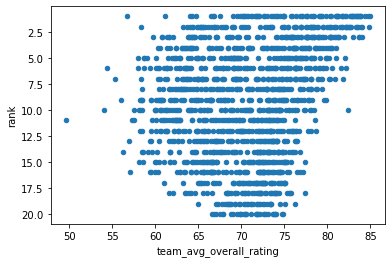

In [45]:
teams_by_season.plot.scatter(x='team_avg_overall_rating', y='rank')
plt.gca().invert_yaxis()

### Matchups

In [8]:
# Matchups

matchups = matches_melt.groupby(by=['country_name', 'league_name', 'team', 'other_team']).agg({'win': ['count', 'sum'], 'loss': 'sum', 'draw': 'sum'})
matchups.columns = ['n_games', 'wins', 'losses', 'draws']
matchups[['perc_wins', 'perc_losses', 'perc_draws']] = matchups[['wins', 'losses', 'draws']].div(matchups.n_games, axis=0)

In [9]:
display(matchups)

n_games  \
country_name league_name              team         other_team                         
Belgium      Belgium Jupiler League   Beerschot AC Club Brugge KV                10   
                                                   FCV Dender EH                  2   
                                                   KAA Gent                      10   
                                                   KAS Eupen                      2   
                                                   KRC Genk                      10   
...                                                                             ...   
Switzerland  Switzerland Super League Servette FC  FC St. Gallen                  4   
                                                   FC Thun                        8   
                                                   FC Zürich                      8   
                                                   Grasshopper Club Zürich        8   
                                                   Neuchâtel Xamax                2   

                                                                            wins  \
country_name league_name              team         other_team                      
Belgium      Belgium Jupiler League   Beerschot AC Club Brugge KV              3   
                                                   FCV Dender EH               1   
                                                   KAA Gent                    3   
                                                   KAS Eupen                   1   
                                                   KRC Genk                    3   
...                                                                          ...   
Switzerland  Switzerland Super League Servette FC  FC St. Gallen               0   
                                                   FC Thun                     1   
                                                   FC Zürich                   3   
                                                   Grasshopper Club Zürich     4   
                                                   Neuchâtel Xamax             1   

                                                                            losses  \
country_name league_name              team         other_team                        
Belgium      Belgium Jupiler League   Beerschot AC Club Brugge KV                6   
                                                   FCV Dender EH                 0   
                                                   KAA Gent                      2   
                                                   KAS Eupen                     0   
                                                   KRC Genk                      5   
...                                                                            ...   
Switzerland  Switzerland Super League Servette FC  FC St. Gallen                 3   
                                                   FC Thun                       5   
                                                   FC Zürich                     3   
                                                   Grasshopper Club Zürich       4   
                                                   Neuchâtel Xamax               0   

                                                                            draws  \
country_name league_name              team         other_team                       
Belgium      Belgium Jupiler League   Beerschot AC Club Brugge KV               1   
                                                   FCV Dender EH                1   
                                                   KAA Gent                     5   
                                                   KAS Eupen                    1   
                                                   KRC Genk                     2   
...                                                                           ...   
Switzerland  Switzerland Super League Servette FC  F

### Old tables with ideas for other statistics

In [10]:
season_stats = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_scors, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals, 
                                        sum(home_team_goal+away_team_goal) AS total_goals                                       
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY Country.name, League.name, season DESC
                                ;""", conn)

matchups = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        COUNT(*) AS games,
                                        COUNT(DISTINCT season) AS seasons,
                                        SUM(home_team_goal) AS home_team_goals, 
                                        SUM(away_team_goal) AS away_team_goal,
                                        SUM(CASE WHEN home_team_goal > away_team_goal THEN 1 ELSE 0 END) AS home_wins,
                                        SUM(CASE WHEN home_team_goal = away_team_goal THEN 1 ELSE 0 END) AS draws,
                                        SUM(CASE WHEN home_team_goal < away_team_goal THEN 1 ELSE 0 END) AS laway_wins
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                GROUP BY
                                    home_team,
                                    away_team;""", conn)

In [6]:
matchups[matchups.home_team == "Real Madrid CF"].sort_values(by="seasons", ascending=False).head(10)

,country_name,league_name,home_team,away_team,games,seasons,home_team_goals,away_team_goal,home_wins,draws,laway_wins
4852,Spain,Spain LIGA BBVA,Real Madrid CF,Athletic Club de Bilbao,8,8,34,9,8,0,0
4859,Spain,Spain LIGA BBVA,Real Madrid CF,FC Barcelona,8,8,12,22,2,1,5
4881,Spain,Spain LIGA BBVA,Real Madrid CF,Valencia CF,8,8,13,7,4,4,0
4878,Spain,Spain LIGA BBVA,Real Madrid CF,Sevilla FC,8,8,27,11,7,0,1
4853,Spain,Spain LIGA BBVA,Real Madrid CF,Atlético Madrid,8,8,13,8,4,1,3
4864,Spain,Spain LIGA BBVA,Real Madrid CF,Málaga CF,8,8,25,7,6,2,0
4860,Spain,Spain LIGA BBVA,Real Madrid CF,Getafe CF,8,8,32,9,8,0,0
4868,Spain,Spain LIGA BBVA,Real Madrid CF,RCD Espanyol,8,8,27,5,6,2,0
4882,Spain,Spain LIGA BBVA,Real Madrid CF,Villarreal CF,7,7,22,7,6,1,0
4863,Spain,Spain LIGA BBVA,Real Madrid CF,Levante UD,6,6,19,3,6,0,0


In [20]:
matchups.to_csv('matchups.csv')
teams_by_season['avg_overall_rating_discrete'] = pd.cut(teams_by_season['team_avg_overall_rating'], bins=20)
teams_by_season.to_csv('teams_by_season.csv')

In [14]:
teams_by_season.team_avg_overall_rating.describe()


count    1478.000000
mean       70.608713
std         5.987514
min        49.592949
25%        66.066731
50%        71.014004
75%        74.776759
max        84.977273
Name: team_avg_overall_rating, dtype: float64